#**Final Project - Basics of deep learning**

#**Name and ID:**

Student 1: Ilan Brilovitch 322525072


Student 2: Chen Shalev 313584906


Student 3: Lin Tibi 318232139



#**Import Libraries**


In [ ]:
%%capture
import re
import math
import functools
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
from sklearn import metrics
from keras import backend as K
from google.colab import drive
from sklearn.utils import shuffle
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD
from keras.models import load_model
import os
import json
import shutil
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


#**Load Dataset**

Chest X-Ray Images (Pneumonia)

In [ ]:

# Your Kaggle credentials
kaggle_credentials = {
    "username": "ilanbrilovitch",
    "key": "0f1ee3dac62e187e2b0fbd8290e20b79"
}

# Create the Kaggle directory if it doesn't exist
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# Write the Kaggle credentials to the kaggle.json file
kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")
with open(kaggle_json_path, "w") as kaggle_file:
    json.dump(kaggle_credentials, kaggle_file)

# Set the appropriate permissions
os.chmod(kaggle_json_path, 0o600)

print("Kaggle credentials set successfully!")

Kaggle credentials set successfully!


In [ ]:
!pip install -q kaggle

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

!unzip -q chest-xray-pneumonia.zip

 99% 2.28G/2.29G [00:17<00:00, 247MB/s]
100% 2.29G/2.29G [00:17<00:00, 143MB/s]


#**loading weights**

In [ ]:
!pip install gdown
import gdown


json_url = 'https://drive.google.com/uc?id=1i32WYld7dv9JRH-11x-9nix5T6N7G8Uo'
json_output = 'history_a1.json'

gdown.download(json_url, json_output, quiet=False)





h5_url = 'https://drive.google.com/uc?id=1QyLGDhNkw-fQT64GVi4JCp08ga_dnyFu'    # Modified URL to get the file directly, this file is binary
h5_output = 'model_a1.h5'

gdown.download(h5_url, h5_output, quiet=False)





url = 'https://drive.google.com/uc?id=1IYEYgoOvQqNxwL3FlWF4gVEAv2-j08cf'
output = 'history_a2.json'

gdown.download(url, output, quiet=False)




url = 'https://drive.google.com/uc?id=1QcvHU5HS-AvpR0ewhbPt9A1gACD66qKA'  # Modified URL to get the file directly, this file is binary
output = 'model_a2.h5'

gdown.download(url, output, quiet=False)






# Download the JSON file
url_json = 'https://drive.google.com/uc?id=190g5K5ZiDa4Zez7SPTqTRqoFTpNtcrlw'
output_json = 'history_d.json'

gdown.download(url_json, output_json, quiet=False)


# Download the binary file (assuming it's a TensorFlow model in HDF5 format)
url_h5 = 'https://drive.google.com/uc?id=1c-dwW-5OuMl63HLcA2vNTwOC4CXpRYKR'
output_h5 = 'model_d.h5'

gdown.download(url_h5, output_h5, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1i32WYld7dv9JRH-11x-9nix5T6N7G8Uo
To: /content/history_a1.json
100%|██████████| 686/686 [00:00<00:00, 627kB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QyLGDhNkw-fQT64GVi4JCp08ga_dnyFu
From (redirected): https://drive.google.com/uc?id=1QyLGDhNkw-fQT64GVi4JCp08ga_dnyFu&confirm=t&uuid=4ae9771f-f751-4a86-9d00-4bea2af8215b
To: /content/model_a1.h5
100%|██████████| 169M/169M [00:01<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1IYEYgoOvQqNxwL3FlWF4gVEAv2-j08cf
To: /content/history_a2.json
100%|██████████| 1.10k/1.10k [00:00<00:00, 3.36MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QcvHU5HS-AvpR0ewhbPt9A1gACD66qKA
From (redirected): https://drive.google.com/uc?id=1QcvHU5HS-AvpR0ewhbPt9A1gACD66qKA&confirm=t&uuid=61c2a504-26f3-49f0-9291-ff2283b23050
To: /content/model_a2.h5
100%|██████████| 255M/255M [00:07<00:00, 36.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=

'model_d.h5'

#**Question 1.a -**

#**Chest X-ray Image Data Augmentation for Classification Using Keras**
This script utilizes the Keras library to implement image data augmentation for a chest X-ray classification task. It loads training, validation, and test data from specified directories and applies different augmentation techniques to the training data, such as rescaling, shearing, zooming, and horizontal flipping. The script then sets up separate data generators for training, validation, and test datasets, ensuring that the images are preprocessed and ready for a convolutional neural network (CNN) to classify them into different categories.

The target image size is set to (224, 224), and the batch size is defined as 32 for each generator. The class mode is set to 'categorical,' indicating that the classification task involves multiple classes.

In [ ]:
# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Set up data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Set up data augmentation for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Load and preprocess validation data
val_generator = val_test_datagen.flow_from_directory(train_dir,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical')

# Load and preprocess test data
test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#**Fine-Tuning VGG16 for Pneumonia Detection**

 This code uses the VGG16 convolutional neural network as a base model, removes its top layers, and builds a new model for pneumonia detection with a softmax output layer, employing categorical crossentropy loss and Adam optimizer.

In [ ]:


# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 3 output classes: healthy, pneumonia

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 0s 0us/step


#**Training 1**





#**Training a Neural Network Model for Image Classification**

 This code snippet utilizes the Keras fit function to train a neural network model for image classification with 10 epochs, using training data provided by train_generator and validating on val_generator

In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
163/163 [==============================] - 204s 1s/step - loss: 1.0710 - accuracy: 0.7253 - val_loss: 0.5719 - val_accuracy: 0.7429
Epoch 2/10
163/163 [==============================] - 206s 1s/step - loss: 0.5841 - accuracy: 0.7419 - val_loss: 0.5702 - val_accuracy: 0.7429
Epoch 3/10
163/163 [==============================] - 171s 1s/step - loss: 0.5709 - accuracy: 0.7429 - val_loss: 0.5700 - val_accuracy: 0.7429
Epoch 4/10
163/163 [==============================] - 170s 1s/step - loss: 0.5703 - accuracy: 0.7429 - val_loss: 0.5700 - val_accuracy: 0.7429
Epoch 5/10
163/163 [==============================] - 169s 1s/step - loss: 0.5707 - accuracy: 0.7429 - val_loss: 0.5706 - val_accuracy: 0.7429
Epoch 6/10
163/163 [==============================] - 169s 1s/step - loss: 0.5706 - accuracy: 0.7429 - val_loss: 0.5700 - val_accuracy: 0.7429
Epoch 7/10
163/163 [==============================] - 169s 1s/step - loss: 0.5711 - accuracy: 0.7429 - val_loss: 0.5702 - val_accuracy: 0.7429

#**Evaluating, Analyzing, and Visualizing a Neural Network Model for Image Classification**

 This code calculates test loss and accuracy, generates predictions on a test set, computes a confusion matrix, extracts true positives, true negatives, false positives, and false negatives, and plots the training and validation accuracy as well as the loss over epochs.

20/20 [==============================] - 6s 288ms/step - loss: 0.6941 - accuracy: 0.6250
Test Accuracy: 62.50%
20/20 [==============================] - 5s 261ms/step

Confusion Matrix:
[[  0 234]
 [  0 390]]

True Positives: 390
True Negatives: 0
False Positives: 234
False Negatives: 0


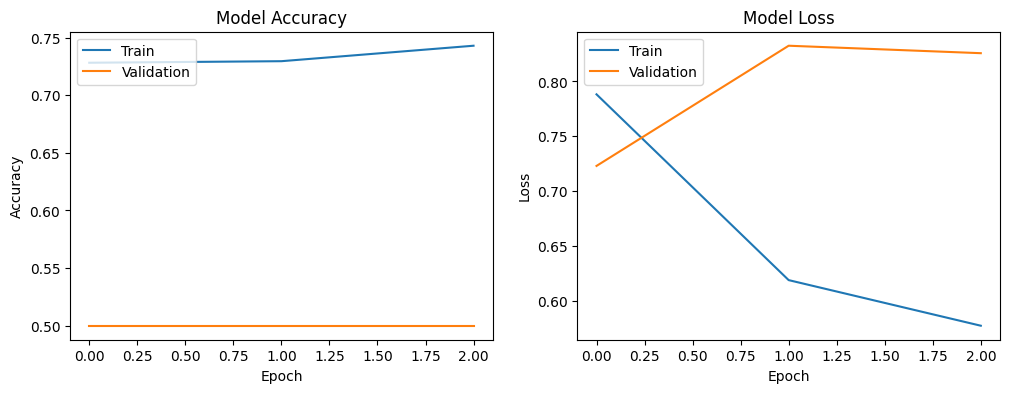

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = confusion_matrix.ravel()

# Display confusion matrix
print(f'\nConfusion Matrix:\n{confusion_matrix}')

# Display True Positives, True Negatives, False Positives, False Negatives
print(f'\nTrue Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#**Training 2**





#**Learning Rate Scheduler**
This sophisticated mechanism dynamically refines the learning rate, facilitating the identification of an ideal rate and contributing to improved convergence during the training process.

In [ ]:


# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    return initial_lr * 0.9 ** epoch

# Use the learning rate scheduler during model training
lr_scheduler = LearningRateScheduler(lr_schedule)


In [ ]:
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    callbacks=[lr_scheduler])
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/10
163/163 [==============================] - 128s 780ms/step - loss: 0.5703 - accuracy: 0.7429 - val_loss: 0.6964 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 136s 832ms/step - loss: 0.5708 - accuracy: 0.7429 - val_loss: 0.6852 - val_accuracy: 0.6250 - lr: 9.0000e-04
Epoch 3/10
163/163 [==============================] - 131s 802ms/step - loss: 0.5709 - accuracy: 0.7429 - val_loss: 0.6973 - val_accuracy: 0.6250 - lr: 8.1000e-04
Epoch 4/10
163/163 [==============================] - 141s 866ms/step - loss: 0.5705 - accuracy: 0.7429 - val_loss: 0.6931 - val_accuracy: 0.6250 - lr: 7.2900e-04
Epoch 5/10
163/163 [==============================] - 124s 758ms/step - loss: 0.5703 - accuracy: 0.7429 - val_loss: 0.6971 - val_accuracy: 0.6250 - lr: 6.5610e-04
Epoch 6/10
163/163 [==============================] - 124s 757ms/step - loss: 0.5704 - accuracy: 0.7429 - val_loss: 0.6919 - val_accuracy: 0.6250 - lr: 5.9049e-04
Epoch 7/10
163/163 [======

20/20 [==============================] - 5s 259ms/step - loss: 0.6956 - accuracy: 0.6250
Test Accuracy: 62.50%
20/20 [==============================] - 6s 289ms/step

Confusion Matrix:
[[  0 234]
 [  0 390]]

True Positives: 390
True Negatives: 0
False Positives: 234
False Negatives: 0


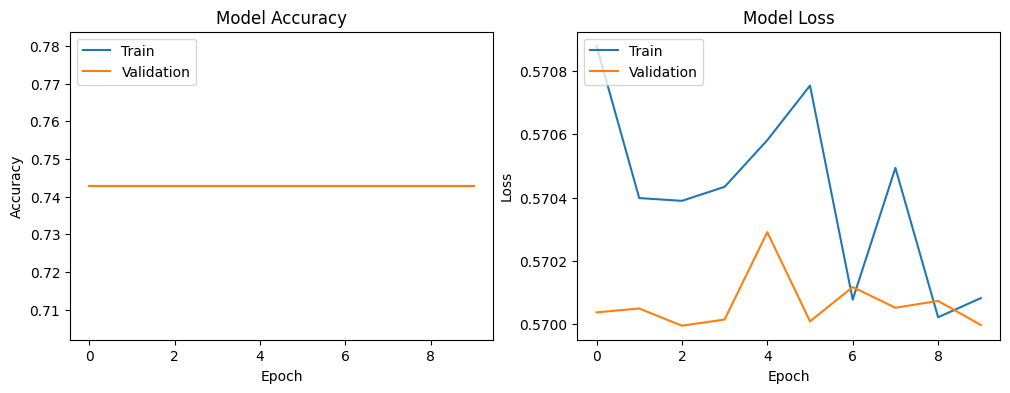

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = confusion_matrix.ravel()

# Display confusion matrix
print(f'\nConfusion Matrix:\n{confusion_matrix}')

# Display True Positives, True Negatives, False Positives, False Negatives
print(f'\nTrue Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#**Training 3**

#**Early Stopping**
Early stopping is an optimization technique that aims to prevent neural networks from overfitting learning to the training test. During training, we find it difficult to know in advance how many options each model has to learn, so the ability to identify the appropriate point for an early stop is important

#**Momentum**
Momentum is a term related to the optimization of machine learning algorithms, mainly in the context of their purpose to specify the direction and speed of the solution processes (gradient descent).

In [ ]:


# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    return initial_lr * 0.9 ** epoch

# Use the learning rate scheduler during model training
lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:


# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Define SGD optimizer with momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

20/20 [==============================] - 6s 297ms/step - loss: 0.1733 - accuracy: 0.9439
Test Accuracy: 94.39%
20/20 [==============================] - 5s 251ms/step

Confusion Matrix:
[[ 87 147]
 [128 262]]

True Positives: 262
True Negatives: 87
False Positives: 147
False Negatives: 128


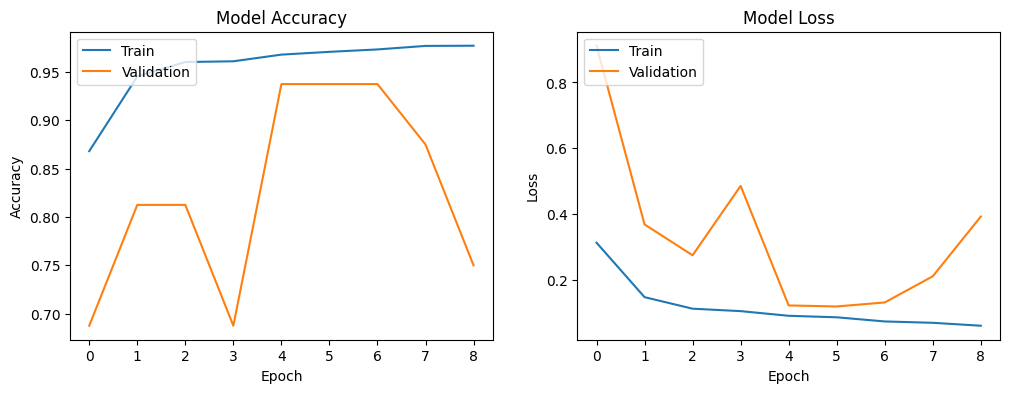

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = confusion_matrix.ravel()

# Display confusion matrix
print(f'\nConfusion Matrix:\n{confusion_matrix}')

# Display True Positives, True Negatives, False Positives, False Negatives
print(f'\nTrue Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#**Classification Healthy / Sick**

#**test 1.a- Classification Healthy / Sick**

In [ ]:
# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Set up data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Set up data augmentation for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Load and preprocess validation data
val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical')

# Load and preprocess test data
test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:


# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of VGG16
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))  # 2 output classes: healthy, pneumonia

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:


# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.001
    return initial_lr * 0.9 ** epoch

# Use the learning rate scheduler during model training
lr_scheduler = LearningRateScheduler(lr_schedule)





# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model_a1.h5', monitor='val_loss', save_best_only=True)

# Define SGD optimizer with momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
163/163 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9070

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


163/163 [==============================] - 130s 773ms/step - loss: 0.2253 - accuracy: 0.9070 - val_loss: 0.3014 - val_accuracy: 0.8670 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 132s 807ms/step - loss: 0.1442 - accuracy: 0.9467 - val_loss: 0.2602 - val_accuracy: 0.9022 - lr: 9.0000e-04
Epoch 3/10
163/163 [==============================] - 127s 777ms/step - loss: 0.1025 - accuracy: 0.9630 - val_loss: 0.1811 - val_accuracy: 0.9407 - lr: 8.1000e-04
Epoch 4/10
163/163 [==============================] - 126s 773ms/step - loss: 0.0925 - accuracy: 0.9686 - val_loss: 0.3486 - val_accuracy: 0.8974 - lr: 7.2900e-04
Epoch 5/10
163/163 [==============================] - 130s 794ms/step - loss: 0.0829 - accuracy: 0.9712 - val_loss: 0.3679 - val_accuracy: 0.8926 - lr: 6.5610e-04
Epoch 6/10
20/20 [==============================] - 6s 300ms/step - loss: 0.1811 - accuracy: 0.9407
Test Accuracy: 94.07%


20/20 [==============================] - 7s 361ms/step - loss: 0.1811 - accuracy: 0.9407
Test Accuracy: 94.07%
20/20 [==============================] - 6s 300ms/step

Confusion Matrix:
[[ 80 154]
 [147 243]]

True Positives: 243
True Negatives: 80
False Positives: 154
False Negatives: 147


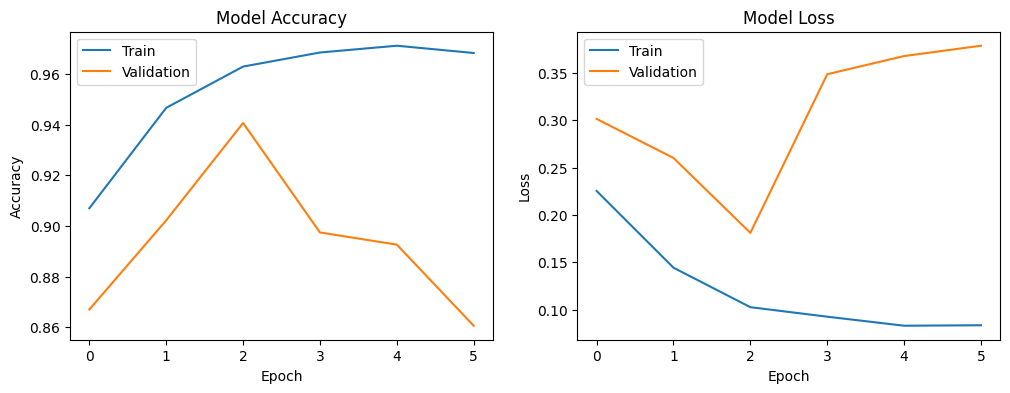

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

# Extract TP, TN, FP, FN
tn, fp, fn, tp = confusion_matrix.ravel()

# Display confusion matrix
print(f'\nConfusion Matrix:\n{confusion_matrix}')

# Display True Positives, True Negatives, False Positives, False Negatives
print(f'\nTrue Positives: {tp}')
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

#**Question 1.a -  if Healthy / Sick**

In [ ]:


# Save the model after training
#model.save('/content/model_a1.h5')

# Save the training history (convert float32 to float for serialization)
#history_dict = history.history
#for key, value in history_dict.items():
  #  history_dict[key] = [float(val) for val in value]

#with open('/content/history_a1.json', 'w') as json_file:
    #json.dump(history_dict, json_file)

# Load the saved model
saved_model = load_model('/content/model_a1.h5')

# Load the training history
with open('/content/history_a1.json') as json_file:
    loaded_history = json.load(json_file)


def classify_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    classes = ['Healthy', 'Sick']

    result = {
        "class": classes[np.argmax(prediction)],
        "confidence": f"{np.max(prediction) * 100:.2f}%"
    }

    return result

# Example 1 - put your image
new_image_path = 'healty.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

# Example 2 - put your image
new_image_path = 'bacteria_482.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')




# Example 3 - put your image
new_image_path = 'Sick.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

# Example 4 - put your image
new_image_path = 'bacterial__google.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')


# Example 5 - put your image
new_image_path = 'viral.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')



1/1 [==============================] - 0s 279ms/step
The image is classified as Healthy with confidence 93.72%
1/1 [==============================] - 0s 53ms/step
The image is classified as Sick with confidence 99.98%
1/1 [==============================] - 0s 48ms/step
The image is classified as Sick with confidence 98.15%
1/1 [==============================] - 0s 28ms/step
The image is classified as Sick with confidence 96.80%
1/1 [==============================] - 0s 33ms/step
The image is classified as Sick with confidence 99.16%


#**Question 1.a - Your check if Healthy / Sick training**

In [ ]:

# Load the saved model
saved_model = load_model('/content/model_a1.h5')

# Load the training history
with open('/content/history_a1.json') as json_file:
    loaded_history = json.load(json_file)


def classify_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    classes = ['Healthy', 'Sick']

    result = {
        "class": classes[np.argmax(prediction)],
        "confidence": f"{np.max(prediction) * 100:.2f}%"
    }

    return result

In [ ]:

# Your Example for check  - put your jpg image
new_image_path = ''
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

#**Question 1.b- Classification healthy / viral pneumonia / bacterial pneumonia**

#**Creating 3 folders for train:**

In [ ]:


# train
# Organize pneumonia data into viral and bacterial subdirectories
pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'
viral_pneumonia_dir = '/content/chest_xray/train/Viral_Pneumonia'
bacterial_pneumonia_dir = '/content/chest_xray/train/Bacterial_Pneumonia'

os.makedirs(viral_pneumonia_dir, exist_ok=True)
os.makedirs(bacterial_pneumonia_dir, exist_ok=True)

for filename in os.listdir(pneumonia_dir):
    if 'virus' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(viral_pneumonia_dir, filename))
    elif 'bacteria' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(bacterial_pneumonia_dir, filename))

# מחיקת התיקייה המקורית PNEUMONIA
shutil.rmtree(pneumonia_dir)




#**Creating 3 folders for val:**

In [ ]:
# val
pneumonia_dir = '/content/chest_xray/val/PNEUMONIA'
viral_pneumonia_dir = '/content/chest_xray/val/Viral_Pneumonia'
bacterial_pneumonia_dir = '/content/chest_xray/val/Bacterial_Pneumonia'

os.makedirs(viral_pneumonia_dir, exist_ok=True)
os.makedirs(bacterial_pneumonia_dir, exist_ok=True)

for filename in os.listdir(pneumonia_dir):
    if 'virus' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(viral_pneumonia_dir, filename))
    elif 'bacteria' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(bacterial_pneumonia_dir, filename))

# מחיקת התיקייה המקורית PNEUMONIA
shutil.rmtree(pneumonia_dir)

#**Creating 3 folders for test:**

In [ ]:
# test
pneumonia_dir = '/content/chest_xray/test/PNEUMONIA'
viral_pneumonia_dir = '/content/chest_xray/test/Viral_Pneumonia'
bacterial_pneumonia_dir = '/content/chest_xray/test/Bacterial_Pneumonia'

os.makedirs(viral_pneumonia_dir, exist_ok=True)
os.makedirs(bacterial_pneumonia_dir, exist_ok=True)

for filename in os.listdir(pneumonia_dir):
    if 'virus' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(viral_pneumonia_dir, filename))
    elif 'bacteria' in filename:
        os.rename(os.path.join(pneumonia_dir, filename), os.path.join(bacterial_pneumonia_dir, filename))

# מחיקת התיקייה המקורית PNEUMONIA
shutil.rmtree(pneumonia_dir)

#**Training a Neural Network Model for Image Classification**

In [ ]:

# Update data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'



# Set up data augmentation for training data
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Set up data augmentation for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

# Load and preprocess validation data
val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='categorical')

# Load and preprocess test data
test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='categorical')


# ... (your existing code for organizing data directories and augmentations)

# Load pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Build your model on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))

model.summary()

# Compile the model with Adam optimizer and categorical_crossentropy loss
optimizer = Adam(learning_rate=0.0001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define a learning rate schedule
def lr_schedule(epoch):
    initial_lr = 0.0001
    return initial_lr * 0.9 ** epoch

# Use the learning rate scheduler during model training
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Increased patience

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model_a2.h5', monitor='val_loss', save_best_only=True)

# Train the model with callbacks
history = model.fit(train_generator,
                    epochs=10,  # Increased epochs
                    validation_data=test_generator,
                    callbacks=[lr_scheduler, early_stopping, checkpoint])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')



Found 5216 images belonging to 3 classes.
Found 16 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0       

#**Evaluating, Analyzing, and Visualizing a Neural Network Model for Image Classification**

 This code calculates test loss and accuracy, generates predictions on a test set, computes a confusion matrix, extracts true positives, true negatives, false positives, and false negatives, and plots the training and validation accuracy as well as the loss over epochs.

20/20 [==============================] - 5s 249ms/step - loss: 0.5241 - accuracy: 0.8397
Test Accuracy: 83.97%
20/20 [==============================] - 5s 267ms/step

Confusion Matrix:
[[117  64  61]
 [101  73  60]
 [ 70  41  37]]

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.48      0.44       242
           1       0.41      0.31      0.35       234
           2       0.23      0.25      0.24       148

    accuracy                           0.36       624
   macro avg       0.35      0.35      0.35       624
weighted avg       0.37      0.36      0.36       624



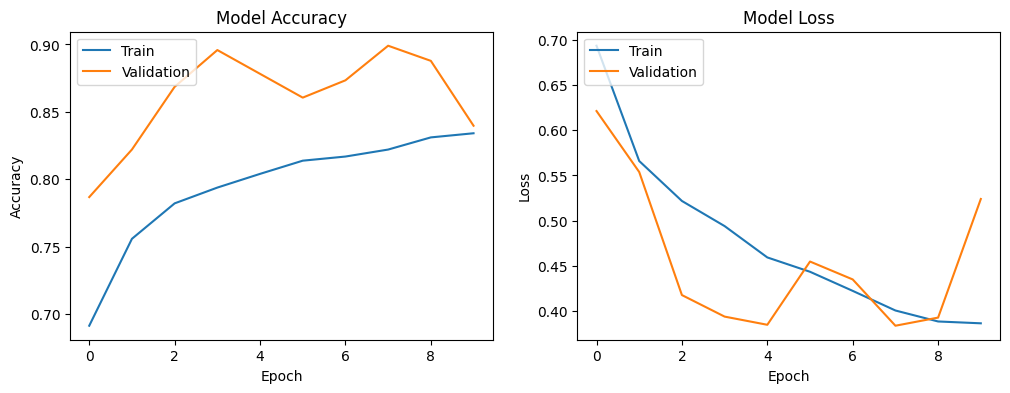

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Make predictions on the test set
predictions = model.predict(test_generator)

# Convert predictions to binary (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = test_generator.classes

# Calculate confusion matrix
confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
print(f'\nConfusion Matrix:\n{confusion_matrix}')

# Calculate other metrics for multi-class classification
classification_report = metrics.classification_report(true_labels, predicted_labels)
print(f'\nClassification Report:\n{classification_report}')

# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


#**Classification healthy / viral pneumonia / bacterial pneumonia**

In [ ]:


# Save the model after training
#model.save('/content/model_a2.h5')

# Save the training history (convert float32 to float for serialization)
#history_dict = history.history
#for key, value in history_dict.items():
   # history_dict[key] = [float(val) for val in value]

#with open('/content/history_a2.json', 'w') as json_file:
   # json.dump(history_dict, json_file)

# Load the saved model
saved_model = load_model('/content/model_a2.h5')

# Load the training history
with open('/content/history_a2.json') as json_file:
    loaded_history = json.load(json_file)


def classify_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
   # classes = ['Healthy', 'Viral Pneumonia', 'Bacterial Pneumonia']
    classes = ['Bacterial Pneumonia', 'Healthy', 'Viral Pneumonia']
    result = {
        "class": classes[np.argmax(prediction)],
        "confidence": f"{np.max(prediction) * 100:.2f}%"
    }

    return result

# Example 1 - put your image
new_image_path = 'healthy.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

# Example 2 - put your image
new_image_path = 'viral.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

# Example 3 - put your image
new_image_path = 'bacteria_482.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

# Example 4 - put your image
new_image_path = 'healthy_google.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')



# Example 5 - put your image
new_image_path = 'bacterial__google.jpg'
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')


1/1 [==============================] - 1s 1s/step
The image is classified as Healthy with confidence 93.53%
1/1 [==============================] - 2s 2s/step
The image is classified as Viral Pneumonia with confidence 52.61%
1/1 [==============================] - 1s 974ms/step
The image is classified as Bacterial Pneumonia with confidence 99.01%
1/1 [==============================] - 1s 1s/step
The image is classified as Viral Pneumonia with confidence 54.86%
1/1 [==============================] - 1s 873ms/step
The image is classified as Bacterial Pneumonia with confidence 53.69%


#**Question 1.b - Your check if healthy / viral pneumonia / bacterial pneumonia**

In [ ]:

# Load the saved model
saved_model = load_model('/content/model_a2.h5')

# Load the training history
with open('/content/history_a2.json') as json_file:
    loaded_history = json.load(json_file)


def classify_image(image_path, model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
   # classes = ['Healthy', 'Viral Pneumonia', 'Bacterial Pneumonia']
    classes = ['Bacterial Pneumonia', 'Healthy', 'Viral Pneumonia']
    result = {
        "class": classes[np.argmax(prediction)],
        "confidence": f"{np.max(prediction) * 100:.2f}%"
    }

    return result

In [ ]:

# Your Example for check  - put your  image
new_image_path = ''
result = classify_image(new_image_path, saved_model)
print(f'The image is classified as {result["class"]} with confidence {result["confidence"]}')

1/1 [==============================] - 1s 729ms/step
The image is classified as Healthy with confidence 93.53%


#**Question 2**

#**Classification using a vector The embedding generated from the classification network and using KNN.**



Utilizing embeddings from a classification network captures meaningful representations of data in a lower-dimensional vector space.
Applying K-nearest neighbors (KNN) on these embeddings allows for effective similarity-based classification or clustering.
Utilizing KNN helps in leveraging learned representations for similarity-based classification, enabling efficient and effective grouping of similar data points in the embedding space.

#**2 for 1.a**

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Accuracy of KNN classifier: 96.84%


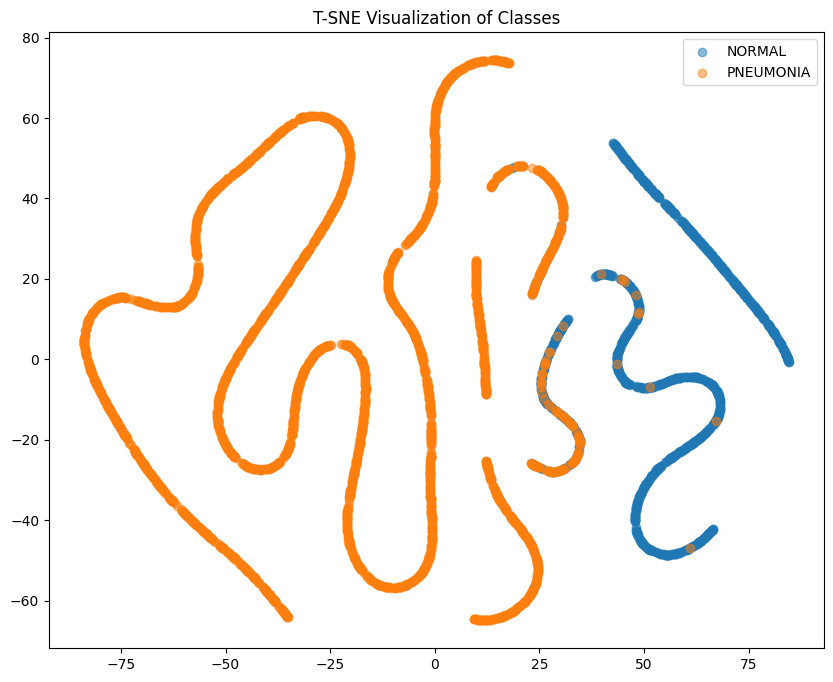

1/1 [==============================] - 0s 30ms/step
The image is classified as Sick  using KNN classifier
Accuracy of KNN classifier: 96.84%


In [ ]:


# Load the saved model
saved_model = load_model('/content/model_a1.h5')

# Extract the embedding layer from the model
embedding_layer_model = Model(inputs=saved_model.input, outputs=saved_model.get_layer('dense_11').output)



# Function to extract features from images
def extract_features(directory, model):
    features = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0
            feature = model.predict(img_array)
            features.append(feature.flatten())
            labels.append(class_folder)
    return np.array(features), np.array(labels)

# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Extract features from training data
train_features, train_labels = extract_features(train_dir, embedding_layer_model)

# Split the data for KNN training and testing
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate KNN classifier on test data
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')

# Visualize classes using T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_features)

# Plot T-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    indices = np.where(train_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=label, alpha=0.5)
plt.legend()
plt.title('T-SNE Visualization of Classes')
plt.show()

# Function to classify image using KNN
def classify_image_knn(image_path, knn_model, embedding_model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    feature = embedding_model.predict(img_array).flatten()
    prediction = knn_model.predict([feature])

    return prediction[0]

# Example - put your image
new_image_path = 'bacteria_482.jpg'  # Provide the path to your image

# Convert the label to uppercase to match the labels in the training data
knn_prediction = classify_image_knn(new_image_path, knn_classifier, embedding_layer_model).upper()


# Print the department name instead of a department number
department_names = {'NORMAL': 'Healthy ', 'PNEUMONIA': 'Sick '}
print(f'The image is classified as {department_names[knn_prediction]} using KNN classifier')
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')



In [ ]:
# Example - put your image
new_image_path = 'bacteria_482.jpg'  # Provide the path to your image

# Convert the label to uppercase to match the labels in the training data
knn_prediction = classify_image_knn(new_image_path, knn_classifier, embedding_layer_model).upper()


# Print the department name instead of a department number
department_names = {'NORMAL': 'Healthy ', 'PNEUMONIA': 'Sick '}
print(f'The image is classified as {department_names[knn_prediction]} using KNN classifier')
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')


1/1 [==============================] - 0s 32ms/step
The image is classified as Sick  using KNN classifier
Accuracy of KNN classifier: 96.84%


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 19ms/step
Accuracy of KNN classifier: 96.84%


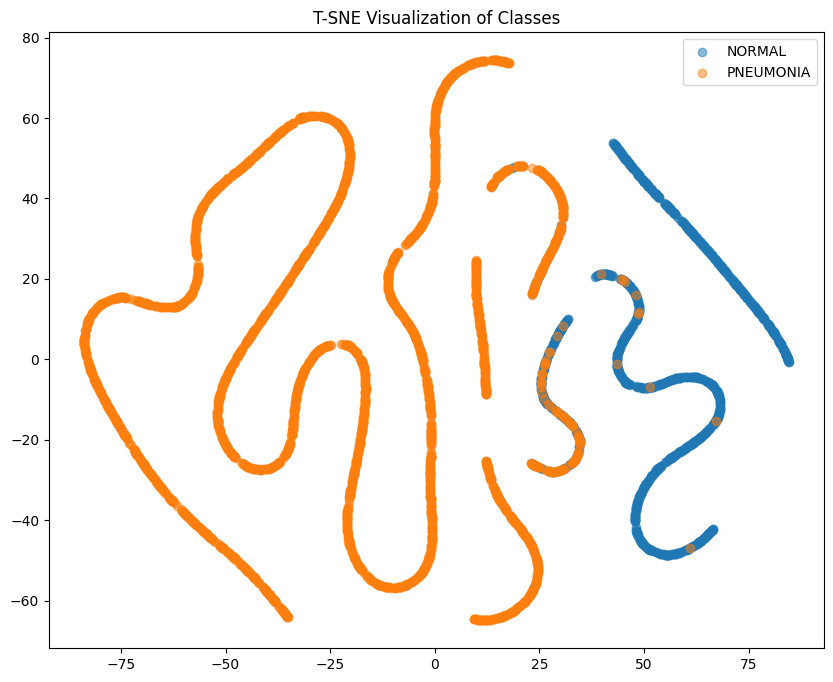

1/1 [==============================] - 0s 22ms/step
The image is classified as Healthy  using KNN classifier
Accuracy of KNN classifier: 96.84%


In [ ]:


# Load the saved model
saved_model = load_model('/content/model_a1.h5')

# Extract the embedding layer from the model
embedding_layer_model = Model(inputs=saved_model.input, outputs=saved_model.get_layer('dense_11').output)



# Function to extract features from images
def extract_features(directory, model):
    features = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0
            feature = model.predict(img_array)
            features.append(feature.flatten())
            labels.append(class_folder)
    return np.array(features), np.array(labels)

# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Extract features from training data
train_features, train_labels = extract_features(train_dir, embedding_layer_model)

# Split the data for KNN training and testing
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate KNN classifier on test data
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')

# Visualize classes using T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_features)

# Plot T-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    indices = np.where(train_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=label, alpha=0.5)
plt.legend()
plt.title('T-SNE Visualization of Classes')
plt.show()

# Function to classify image using KNN
def classify_image_knn(image_path, knn_model, embedding_model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    feature = embedding_model.predict(img_array).flatten()
    prediction = knn_model.predict([feature])

    return prediction[0]

# Example - put your image
new_image_path = 'healthy.jpg'  # Provide the path to your image

# Convert the label to uppercase to match the labels in the training data
knn_prediction = classify_image_knn(new_image_path, knn_classifier, embedding_layer_model).upper()


# Print the department name instead of a department number
department_names = {'NORMAL': 'Healthy ', 'PNEUMONIA': 'Sick '}
print(f'The image is classified as {department_names[knn_prediction]} using KNN classifier')
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')



#**2 for 1.b**

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Accuracy of KNN classifier: 81.03%


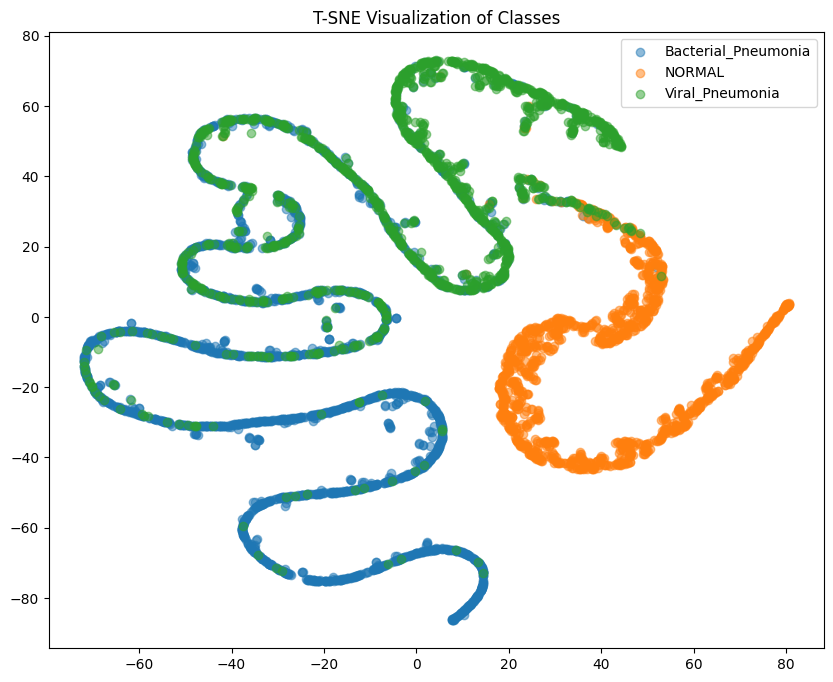

1/1 [==============================] - 0s 24ms/step
The image is classified as Healthy B using KNN classifier
Accuracy of KNN classifier: 81.03%


In [ ]:
# Load the saved model
saved_model = load_model('/content/model_a2.h5')

# Extract the embedding layer from the model
embedding_layer_model = Model(inputs=saved_model.input, outputs=saved_model.get_layer('dense_5').output)


# Function to extract features from images
def extract_features(directory, model):
    features = []
    labels = []
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array /= 255.0
            feature = model.predict(img_array)
            features.append(feature.flatten())
            labels.append(class_folder)
    return np.array(features), np.array(labels)

# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Extract features from training data
train_features, train_labels = extract_features(train_dir, embedding_layer_model)

# Split the data for KNN training and testing
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=3)
knn_classifier.fit(X_train, y_train)

# Evaluate KNN classifier on test data
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')

# Visualize classes using T-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(train_features)

# Plot T-SNE results
plt.figure(figsize=(10, 8))
for label in np.unique(train_labels):
    indices = np.where(train_labels == label)
    plt.scatter(tsne_result[indices, 0], tsne_result[indices, 1], label=label, alpha=0.5)
plt.legend()
plt.title('T-SNE Visualization of Classes')
plt.show()




# Function to classify image using KNN
def classify_image_knn(image_path, knn_classifier, embedding_model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    feature = embedding_model.predict(img_array).flatten()
    prediction = knn_classifier.predict([feature])

    return prediction[0]

# Example 2 - put your image
new_image_path = 'healthy.jpg'  # Provide the path to your image
knn_prediction = classify_image_knn(new_image_path, knn_classifier, embedding_layer_model)
# Print the department name instead of a department number
department_names = {'Bacterial Pneumonia': 'Bacterial Pneumonia', 'NORMAL': 'Healthy ', 'Viral Pneumonia': 'Viral Pneumonia'}
print(f'The image is classified as {department_names[knn_prediction]} using KNN classifier')
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')

In [ ]:

# Function to classify image using KNN
def classify_image_knn(image_path, knn_classifier, embedding_model):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    feature = embedding_model.predict(img_array).flatten()
    prediction = knn_classifier.predict([feature])

    return prediction[0]

# Example 2 - put your image
new_image_path = 'healthy.jpg'  # Provide the path to your image
knn_prediction = classify_image_knn(new_image_path, knn_classifier, embedding_layer_model)
# Print the department name instead of a department number
department_names = {'Bacterial Pneumonia': 'Bacterial Pneumonia', 'NORMAL': 'Healthy ', 'Viral Pneumonia': 'Viral Pneumonia'}
print(f'The image is classified as {department_names[knn_prediction]} using KNN classifier')
print(f'Accuracy of KNN classifier: {accuracy * 100:.2f}%')

1/1 [==============================] - 0s 49ms/step
The image is classified as Healthy B using KNN classifier
Accuracy of KNN classifier: 81.03%


#**Question 4- Anomaly Detection**

Anomaly detection refers to the identification of patterns or instances that deviate significantly from the norm or expected behavior within a dataset.

In [ ]:
# we need just normal


# train
# Organize pneumonia data into viral and bacterial subdirectories
pneumonia_dir = '/content/chest_xray/train/PNEUMONIA'

# מחיקת התיקייה המקורית PNEUMONIA
shutil.rmtree(pneumonia_dir)




In [ ]:


# Define data directories
train_dir = '/content/chest_xray/train'
val_dir = '/content/chest_xray/val'
test_dir = '/content/chest_xray/test'

# Set up data augmentation for healthy training data
healthy_train_datagen = ImageDataGenerator(rescale=1./255,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)

# Load and preprocess healthy training data
healthy_train_generator = healthy_train_datagen.flow_from_directory(train_dir,
                                                                    target_size=(224, 224),
                                                                    batch_size=32,
                                                                    class_mode='input')

# Build the autoencoder model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(224*224*3, activation='sigmoid'))
model.add(Reshape((224, 224, 3)))

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error')


# Continue training or fit the model
model.fit(healthy_train_generator,
          epochs=10,
          steps_per_epoch=len(healthy_train_generator),
          verbose=1)

# Save the model
model.save('/content/model_d.h5')

# Save the training history
history = model.history.history
with open('/content/history_d.json', 'w') as json_file:
    json.dump(history, json_file)

# Load the saved model
saved_model = load_model('/content/model_d.h5')

# Load the training history
with open('/content/history_d.json') as json_file:
    loaded_history = json.load(json_file)



# Load and preprocess a single image for anomaly detection
image_path = 'healthy.jpg'  # Change this to the path of the new image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # rescale to [0,1]

# Predict and calculate reconstruction errors
anomaly_predictions = model.predict(img_array, verbose=1)
anomaly_errors = np.mean(np.square(img_array - anomaly_predictions))

# Set a threshold for anomaly detection (you may need to adjust this based on your data)
threshold = 0.01

# Classify image as healthy or sick based on the threshold
anomaly_label = 'healthy' if anomaly_errors < threshold else 'sick'

print("Anomaly Label:", anomaly_label)
print("Anomaly Errors:", anomaly_errors)


Found 1341 images belonging to 1 classes.
Epoch 1/10
42/42 [==============================] - 201s 5s/step - loss: 0.0339
Epoch 2/10
42/42 [==============================] - 204s 5s/step - loss: 0.0218
Epoch 3/10
42/42 [==============================] - 204s 5s/step - loss: 0.0200
Epoch 4/10
42/42 [==============================] - 193s 5s/step - loss: 0.0187
Epoch 5/10
42/42 [==============================] - 195s 5s/step - loss: 0.0169
Epoch 6/10
42/42 [==============================] - 205s 5s/step - loss: 0.0155
Epoch 7/10
42/42 [==============================] - 193s 5s/step - loss: 0.0145
Epoch 8/10
42/42 [==============================] - 194s 5s/step - loss: 0.0140
Epoch 9/10
42/42 [==============================] - 204s 5s/step - loss: 0.0138
Epoch 10/10
42/42 [==============================] - 212s 5s/step - loss: 0.0135


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 175ms/step
Anomaly Label: sick
Anomaly Errors: 0.012021444


#**Question 4- your check for Anomaly Detection**

In [ ]:


# Load the saved model
saved_model = load_model('/content/model_d.h5')

# Load the training history
with open('/content/history_d.json') as json_file:
    loaded_history = json.load(json_file)



# Load and preprocess a single image for anomaly detection
image_path = 'viralgoogle.jpg'  # Change this to the path of the new image
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # rescale to [0,1]

# Predict and calculate reconstruction errors
anomaly_predictions = saved_model.predict(img_array, verbose=1)
anomaly_errors = np.mean(np.square(img_array - anomaly_predictions))

# Set a threshold for anomaly detection (you may need to adjust this based on your data)
threshold = 0.02

# Classify image as healthy or sick based on the threshold
anomaly_label = 'healthy' if anomaly_errors < threshold else 'sick'

print("Anomaly Label:", anomaly_label)
print("Anomaly Errors:", anomaly_errors)

1/1 [==============================] - 3s 3s/step
Anomaly Label: sick
Anomaly Errors: 0.037600223
